In [ ]:
import datetime as dt
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data_start = dt.datetime(2022, 1, 1)
data_finish = dt.datetime(2022, 12, 31)+relativedelta(hours = 23, minutes = 30)

In [ ]:
data_range = pd.date_range(data_start, data_finish, freq = "0.5H")
coords_data = pd.Series(np.random.randn(len(data_range)), index = data_range).to_frame(name = "temperature")

In [ ]:
daytemplist = [0, 6, 5, 17, 20, 29, 30, 33, 22, 15, 8, 2]
nighttemplist = [-2, 1, -2, 9, 10, 18, 19, 22, 14, 12, 7, 0]
meantemplist = [-0.9, 3.3, 1.5, 12.8, 15.2, 23.5, 24.2, 26.5, 17.2, 11.5, 5.0, 0.1]
relhumiditylist = [0.85, 0.84, 0.6, 0.72, 0.61, 0.51, 0.53, 0.45, 0.63, 0.72, 0.77, 0.77]

In [ ]:
coords_data["temperature"] = pd.NaT
coords_data["atmpressure"] = pd.NaT
coords_data["relhumidity"] = pd.NaT
coords_data["illuminance"] = pd.NaT

In [ ]:
coords_data.head()

,temperature,atmpressure,relhumidity,illuminance
2022-01-01 00:00:00,NaT,NaT,NaT,NaT
2022-01-01 00:30:00,NaT,NaT,NaT,NaT
2022-01-01 01:00:00,NaT,NaT,NaT,NaT
2022-01-01 01:30:00,NaT,NaT,NaT,NaT
2022-01-01 02:00:00,NaT,NaT,NaT,NaT


In [ ]:
def CalculateAtmosphericPressure(P_0, h, T):
  '''
  Вычисляет атмосферное давление в гектопаскалях.
  P_0 - давление на уровне моря, в гектопаскалях.
  h - высота над уровнем моря, в метрах.
  T - температура, в Цельсиях.
  '''
  return P_0*np.power(1-(0.0065*h/(T+0.0065*h+273.15)), 5.257)
temp_bias = 5
relhumidity_bias = 0.05
daynightperclist = {}
daynightperclist.update({data_start.date(): (8*60+34)/60/24}) #1 января 2022 года.
daynightperclist.update({(data_start+relativedelta(months = 2, days = 19)).date(): (12*60+10)/60/24}) #20 марта 2022 года.
daynightperclist.update({(data_start+relativedelta(months = 5, days = 20)).date(): (15*60+55)/60/24}) #21 июня 2022 года.
daynightperclist.update({(data_start+relativedelta(months = 8, days = 22)).date(): (12*60+7)/60/24}) #23 сентября 2022 года.
daynightperclist.update({(data_start+relativedelta(months = 11, days = 30)).date(): (8*60+32)/60/24}) #31 декабря 2022 года.
def RelativeWeatherFunction(delta, min_value, max_value):
  '''
  Функция, возвращающая новое значение для параболы min_value -> max_value -> min_value по заданной delta, используя np.sin в промежутке от 0 до np.pi.
  '''
  if delta >= 1.0 or delta <= 0.0:
    return min_value
  if delta == 0.5:
    return max_value
  f = np.sin(delta*np.pi)
  return (f*(max_value-min_value))+min_value
current_daylightperc = daynightperclist[data_start.date()]
for i in range(0, 12):
  d1 = data_start+relativedelta(months = i)
  d2 = data_start+relativedelta(months = i+1, hours = -1)
  for day_timestamp in pd.date_range(d1, d2, freq = "D"):
    day_mintemp = nighttemplist[i]+np.random.uniform(-1*temp_bias, temp_bias)
    day_maxtemp = daytemplist[i]+np.random.uniform(-1*temp_bias, temp_bias)
    day_minrelhumidity = relhumiditylist[i]-np.random.uniform(-1*relhumidity_bias, relhumidity_bias)
    day_maxrelhumidity = relhumiditylist[i]+np.random.uniform(-1*relhumidity_bias, relhumidity_bias)
    timestamp_date = day_timestamp.date()
    if timestamp_date in daynightperclist:
      current_daylightperc = daynightperclist[timestamp_date]
    else:
      dn_date_left = timestamp_date
      dn_date_right = timestamp_date
      for dn_date in daynightperclist:
        if timestamp_date < dn_date:
          if dn_date_right == timestamp_date or dn_date_right > dn_date:
            dn_date_right = dn_date
        elif timestamp_date > dn_date:
          if dn_date_left == timestamp_date or dn_date_left < dn_date:
            dn_date_left = dn_date
      if timestamp_date != dn_date_left and timestamp_date != dn_date_right:
        date_relative = (timestamp_date-dn_date_left).days/(dn_date_right-dn_date_left).days
        daylightperc_left = daynightperclist[dn_date_left]
        daylightperc_right = daynightperclist[dn_date_right]
        if daylightperc_left > daylightperc_right:
          current_daylightperc = RelativeWeatherFunction(0.5*(1.0-date_relative), daylightperc_right, daylightperc_left)
        else:
          current_daylightperc = RelativeWeatherFunction(0.5*date_relative, daylightperc_left, daylightperc_right)
    for j in range(0, 48):
      dayhour_timestamp = day_timestamp+relativedelta(hours = 0.5*j)
      n = RelativeWeatherFunction(j/48, day_mintemp, day_maxtemp)
      coords_data.loc[dayhour_timestamp, "temperature"] = n
      coords_data.loc[dayhour_timestamp, "atmpressure"] = 0.75*CalculateAtmosphericPressure(1310, 72, n)
      coords_data.loc[dayhour_timestamp, "relhumidity"] = 100.0*RelativeWeatherFunction(j/48, day_minrelhumidity, day_maxrelhumidity)
      coords_data.loc[dayhour_timestamp, "illuminance"] = 100000.0*current_daylightperc

In [ ]:
coords_data.to_csv("Padalko_LR1_WeatherData.csv")
coords_data.head()

,temperature,atmpressure,relhumidity,illuminance
2022-01-01 00:00:00,-0.432882,973.683914,85.372272,35694.444444
2022-01-01 00:30:00,-0.267199,973.689238,85.287472,35694.444444
2022-01-01 01:00:00,-0.102225,973.694533,85.203035,35694.444444
2022-01-01 01:30:00,0.061333,973.699777,85.119322,35694.444444
2022-01-01 02:00:00,0.222774,973.704946,85.036693,35694.444444


Text(0.5, 1.0, 'Сгенерированная температура воздуха в Ростове-на-Дону')

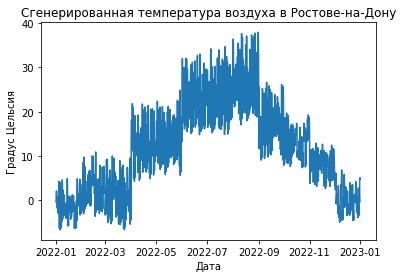

In [ ]:
plt.plot(coords_data["temperature"], label = "Средняя температура за полчаса")
plt.xlabel("Дата")
plt.ylabel("Градус Цельсия")
plt.title("Сгенерированная температура воздуха в Ростове-на-Дону")

Text(0.5, 1.0, 'Сгенерированное атмосферное давление в Ростове-на-Дону')

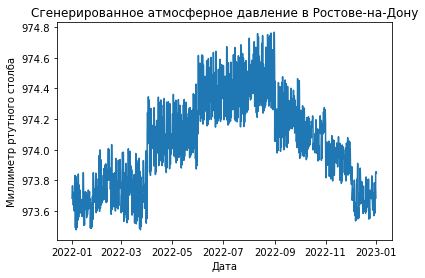

In [ ]:
plt.plot(coords_data["atmpressure"], label = "Среднее атмосферное давление за полчаса")
plt.xlabel("Дата")
plt.ylabel("Миллиметр ртутного столба")
plt.title("Сгенерированное атмосферное давление в Ростове-на-Дону")

Text(0.5, 1.0, 'Сгенерированная относительная влажность воздуха в Ростове-на-Дону')

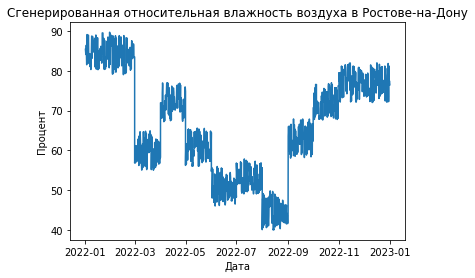

In [ ]:
plt.plot(coords_data["relhumidity"], label = "Средняя относительная влажность воздуха за полчаса")
plt.xlabel("Дата")
plt.ylabel("Процент")
plt.title("Сгенерированная относительная влажность воздуха в Ростове-на-Дону")

Text(0.5, 1.0, 'Сгенерированная освещённость в Ростове-на-Дону')

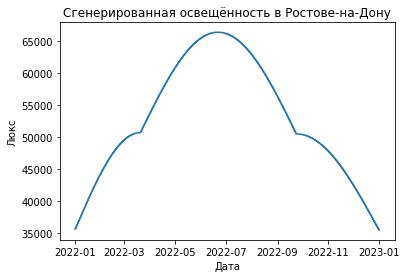

In [ ]:
plt.plot(coords_data["illuminance"], label = "Средняя освещённость")
plt.xlabel("Дата")
plt.ylabel("Люкс")
plt.title("Сгенерированная освещённость в Ростове-на-Дону")